In [1]:
%load_ext autoreload

In [2]:
# imports
%aimport sym
%autoreload 1
import os
import numpy as np
import torch
from torch import nn
import torchvision
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from torchvision import transforms
from sklearn.metrics import classification_report, confusion_matrix
from matplotlib import pyplot as plt
from sym.utils import conv_output_shape
plt.style.use('dark_background')
device = "cuda:0" if torch.cuda.is_available() else "cpu"

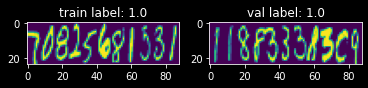

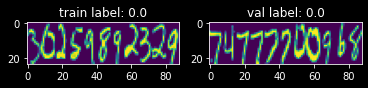

In [3]:
# Import Data
imagenet_data_train = torchvision.datasets.MNIST("./data/", train=True)  
imagenet_data_val = torchvision.datasets.MNIST("./data/", train=False)
# data
n_digits = 11
window = (n_digits-3)//2
h_digit,w_digit = (24,8)
transform = transforms.Compose([transforms.CenterCrop((h_digit,18)),
                                transforms.Resize((h_digit,w_digit)),
                               ])
data = transform(imagenet_data_train.data)
data = data.repeat(n_digits,1,1)
mask = torch.randperm(data.shape[0])
data = data[mask].view(-1,n_digits,h_digit,w_digit) #Shuffle Data
data = data.permute(0,2,1,3).flatten(2) #Concatenate digits
data = data.unsqueeze(1)/255*2-1 # normalize data
targets = imagenet_data_train.targets.repeat(n_digits)
targets = targets[mask]
targets = targets.view(-1,n_digits)[:,window:window+3].sum(axis=1)%2
#targets = 2*targets -1 
targets = targets.view(-1,1)
trainloader =torch.utils.data.DataLoader(torch.utils.data.TensorDataset(data.float(),targets.float()),num_workers=6,
                                          batch_size=256,
                                          shuffle=True)
data = transform(imagenet_data_val.data)
data = data.repeat(n_digits,1,1)
mask = torch.randperm(data.shape[0])
data = data[mask].view(-1,n_digits,h_digit,w_digit)#[:-1]for 3 digits
data = data.permute(0,2,1,3).flatten(2)
data = data.unsqueeze(1)/255*2-1
targets = imagenet_data_val.targets.repeat(n_digits)
targets = targets[mask]
targets = targets.view(-1,n_digits)[:,window:window+3].sum(axis=1)%2 #[:-1] for 3 digits
#targets = 2*targets -1 
targets = targets.view(-1,1)
valloader =torch.utils.data.DataLoader(torch.utils.data.TensorDataset(data.float(),targets.float()),num_workers=6,
                                          batch_size=256,
                                          shuffle=False)
xs,ys =  iter(trainloader).next()
xs2,ys2 =  iter(valloader).next()
i = 0
for x,y,x2,y2 in zip(xs,ys,xs2,ys2):
    i+=1
    fig, axes = plt.subplots(1,2)
    axes[0].set_title(f"train label: {y.item()}")
    axes[1].set_title(f"val label: {y2.item()}")
    axes[0].imshow(x[0])
    axes[1].imshow(x2[0])
    if i==2: break

In [4]:
logdir = "./lightning_logs/MNIST/parity/Adam/11/"
if not os.path.exists(logdir): os.makedirs(logdir,exist_ok=True)
epochs = 30
nfilters = 256
stride=8
kernel_size = 24
hidden = 1024
lr = 2e-4
optim = torch.optim.Adam
#Loss = torch.nn.BCELoss()

# LCN

In [5]:
# Train the LCN 
module = sym.models.LCN(1, out_channels=1, h=h_digit, w=w_digit*n_digits, nfilters=nfilters,hidden=hidden,
                     kernel_size=kernel_size, stride=stride, readout_activation=None)
lcn = sym.models.Model(module,
    optim=optim(module.parameters(),lr=lr))
# Run
pl.seed_everything(42)
bar = sym.utils.ProgressBar()
log = sym.utils.Logger(logdir, name="LCN",default_hp_metric=False)
path = logdir+f"LCN/version_{log.version}"
checkpoint_callback = ModelCheckpoint(dirpath=path,filename="weights.cpkt",save_top_k=1,monitor='val_loss',mode='min')
trainer = pl.Trainer(logger=log, gpus=1, max_epochs=epochs, progress_bar_refresh_rate=1,callbacks=[bar,checkpoint_callback])
trainer.fit(lcn,train_dataloader=trainloader,val_dataloaders=valloader)

Missing logger folder: ./lightning_logs/MNIST/parity/Adam/11/LCN
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params
-------------------------------
0 | model | LCN  | 3.7 M 


Epoch 29: 100%|##########| 275/275 [00:06<00:00, 40.12it/s, loss=0.013, v_num=0, val_loss=0.109, val_acc=0.871] 


1

# CNN

In [6]:
# Train the CNN 
module = sym.models.CNN(1, out_channels=1, h=h_digit, w=w_digit*n_digits,#readout_activation=torch.sigmoid
                     kernel_size=kernel_size, stride=stride,nfilters=nfilters,hidden=hidden )
cnn = sym.models.Model(module,#criterion=Loss,
    optim=optim(module.parameters(),lr=lr))
# Run
pl.seed_everything(42)
bar = sym.utils.ProgressBar()
log = sym.utils.Logger(logdir, name="CNN",default_hp_metric=False)
path = logdir+f"CNN/version_{log.version}"
checkpoint_callback = pl.callbacks.ModelCheckpoint(dirpath=path,filename="weights.cpkt",save_top_k=1,monitor='val_loss',mode='min')
trainer = pl.Trainer(logger=log, gpus=1, max_epochs=epochs, progress_bar_refresh_rate=1,callbacks=[bar,checkpoint_callback])
trainer.fit(cnn,train_dataloader=trainloader,val_dataloaders=valloader)

Missing logger folder: ./lightning_logs/MNIST/parity/Adam/11/CNN
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params
-------------------------------
0 | model | CNN  | 2.5 M 


Epoch 29: 100%|##########| 275/275 [00:02<00:00, 108.15it/s, loss=0.008, v_num=0, val_loss=0.122, val_acc=0.852] 


1

# FCN 

In [7]:
# Train the FCN 
module = sym.models.FCN(1, out_channels=1, h=h_digit, w=w_digit*n_digits, nfilters=nfilters,hidden=hidden,
                     kernel_size=kernel_size, stride=stride, readout_activation=None)
fcn = sym.models.Model(module,
    optim=optim(module.parameters(),lr=lr))
# Run
pl.seed_everything(42)
bar = sym.utils.ProgressBar()
log = sym.utils.Logger(logdir, name="FCN",default_hp_metric=False)
path = logdir+f"FCN/version_{log.version}"
checkpoint_callback = ModelCheckpoint(dirpath=path,filename="weights.cpkt",save_top_k=1,monitor='val_loss',mode='min')
trainer = pl.Trainer(logger=log, gpus=1, max_epochs=epochs, progress_bar_refresh_rate=1,callbacks=[bar,checkpoint_callback])
trainer.fit(fcn,train_dataloader=trainloader,val_dataloaders=valloader)

Missing logger folder: ./lightning_logs/MNIST/parity/Adam/11/FCN
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params
-------------------------------
0 | model | FCN  | 805 K 


Epoch 29: 100%|##########| 275/275 [00:02<00:00, 108.00it/s, loss=0.250, v_num=0, val_loss=0.25, val_acc=0.496]


1

# Embedding FCN 

In [8]:
# Train the FCN 
h_out, w_out = conv_output_shape(h_w=(h_digit, w_digit*n_digits), kernel_size=kernel_size, stride=stride)
module = sym.models.FCN(1, out_channels=1, h=h_digit, w=w_digit*n_digits, nfilters=nfilters*h_out*w_out,
                        hidden=hidden,kernel_size=kernel_size, stride=stride, readout_activation=None)
efcn = sym.models.Model(module,
    optim=optim(module.parameters(),lr=lr))
# Run
pl.seed_everything(42)
bar = sym.utils.ProgressBar()
log = sym.utils.Logger(logdir, name="E-FCN",default_hp_metric=False)
path = logdir+f"E-FCN/version_{log.version}"
checkpoint_callback = ModelCheckpoint(dirpath=path,filename="weights.cpkt",save_top_k=1,monitor='val_loss',mode='min')
trainer = pl.Trainer(logger=log, gpus=1, max_epochs=epochs, progress_bar_refresh_rate=1,callbacks=[bar,checkpoint_callback])
trainer.fit(efcn,train_dataloader=trainloader,val_dataloaders=valloader)

Missing logger folder: ./lightning_logs/MNIST/parity/Adam/11/E-FCN
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params
-------------------------------
0 | model | FCN  | 7.2 M 


Epoch 29: 100%|##########| 275/275 [00:02<00:00, 105.87it/s, loss=0.202, v_num=0, val_loss=0.276, val_acc=0.531]


1